In [533]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [534]:
df = pd.read_csv('datasets/dataset_train.csv')[['Hogwarts House', 'Herbology', 'Defense Against the Dark Arts',
       'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic',
       'Transfiguration', 'Care of Magical Creatures', 'Charms', 'Flying']]
df.head()

,Hogwarts House,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Care of Magical Creatures,Charms,Flying
0,Ravenclaw,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,0.715939,-232.79405,-26.89
1,Slytherin,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,0.091674,-252.18425,-113.45
2,Ravenclaw,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,-0.515327,-227.34265,30.42
3,Gryffindor,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,-0.014040,-256.84675,200.64
4,Gryffindor,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,-0.264070,-256.38730,157.98


In [535]:
# for train: Ravenclaw -> Slytherin -> Gryffindor
target = np.array(['Ravenclaw', 'Slytherin', 'Gryffindor'])
df = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
0,Ravenclaw,272.035831,-232.79405,4.722,-26.89,5.231058,1039.788281
1,Slytherin,-487.340557,-252.18425,-5.612,-113.45,4.107170,1058.944592
2,Ravenclaw,664.893521,-227.34265,6.140,30.42,3.555579,1088.088348
3,Gryffindor,-537.001128,-256.84675,4.026,200.64,-4.809637,920.391449
4,Gryffindor,-444.262537,-256.38730,2.236,157.98,-3.444377,937.434724


In [536]:
df.shape[0]

1600

In [537]:
df.shape[0] - df.dropna().shape[0]

148

In [538]:
df = df.dropna()

In [539]:
df.shape

(1452, 7)

In [540]:
# div = 0.9
# df_test = df.iloc[int(df.shape[0] * div):]
# df = df.iloc[:int(df.shape[0] * div)]
# df.shape

In [541]:
def get_minmax(x):
    x_minmax = np.zeros([x.shape[1], 2], np.float32)
    for i in range(x.shape[1]):
        x_minmax[i] = [x[:, i].min(), x[:, i].max()]
    return x_minmax

def normalization(target, val_min, val_max):
    return (target - val_min) / (val_max - val_min)

def set_xnorm(x, x_minmax):
    for i in range(x.shape[1]):
        x[:, i] = normalization(x[:, i], *x_minmax[i])

y = df.values[:, 0]
x = df.values[:, 1:].astype(np.float32)
x_minmax = get_minmax(x)
set_xnorm(x, x_minmax)
bias = np.ones((x.shape[0], 1))
x = np.concatenate((x, bias), 1)

In [542]:
def sigmoid(predict):
    sigmoid = 1 / (1 + np.exp(-predict))
    return sigmoid

def loss_log(predict, target):
    loss_log = -np.mean(target * np.log(predict) +
                        (1 - target) * np.log(1 - predict))
    return loss_log

def get_vecpredict(x, weight, i):
    predict = sigmoid(np.concatenate([x[:, (i * 2):(i * 2 + 2)],
                                        x[:, -1].reshape(-1, 1)],
                                        axis=1) @\
                        weight[(i * 3):(i * 3 + 3)])
    return predict

def get_bintarget(x, y, target):
    y_bin = np.zeros([target.size, y.size], np.int8)
    for i in range(y_bin.shape[0]):
        y_bin[i] = list(map(lambda x: 1 if x == target[i] else 0, y))
    return y_bin


def set_errorepoch(error, epoch, x, weight, y_bin, target):
    for i in range(target.size):
        error[epoch][i] = loss_log(get_vecpredict(x, weight, i),
                                    y_bin[i])



In [543]:
def predict_error(predict, y, i, target):
    error = predict - int(y[i] == target)
    return error

def sigmoid_derivative(predict):
    derivative = predict * (1 - predict)
    return derivative

def feature_slice(x, i, j):
    slc = np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                        [x[i][-1]]])
    return slc

def get_housepredict(x, weight, i, j):
    predict = sigmoid(np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                                    [1]]) @ weight[(j * 3):(j * 3 + 3)])
    return predict

def fill_delta(delta, x, weight, y, i, target):
    for j in range(target.size):
        predict = get_housepredict(x, weight, i, j)
        delta[(j * 3):(j * 3 + 3)] += predict_error(predict, y,
                                                    i, target[j]) *\
                                        sigmoid_derivative(predict) *\
                                        feature_slice(x, i, j)

def update_weight(weight, delta):
    weight -= delta * alpha
    delta[:] = 0
    return 0

def learning_nn(x, y, target, epochs, alpha, batch, eborder):
    weight = np.random.random(x.shape[1] + target.size - 1)
    delta = np.zeros(weight.size, np.float32)
    error = np.zeros([epochs, 3], np.float32)
    y_bin = get_bintarget(x, y, target)
    cursor = 0
    for epoch in range(epochs):
        set_errorepoch(error, epoch, x, weight, y_bin, target)        
        if np.all([i < eborder for i in error[epoch]]):
            return weight, error
        for i in range(x.shape[0]):
            fill_delta(delta, x, weight, y, i, target)
            cursor += 1
            if cursor == batch:
                cursor = update_weight(weight, delta)
        cursor = update_weight(weight, delta)
        np.random.shuffle([x, y])
    return weight, error

epochs = 300
alpha = 0.01
batch = 500
eborder = 0.1
weight, error = learning_nn(x, y, target, epochs, alpha, batch, eborder)


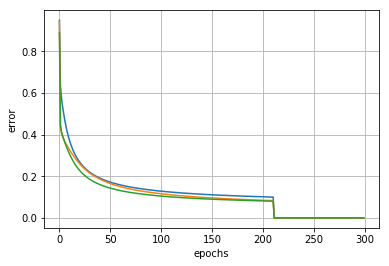

In [544]:
plt.plot(range(epochs), error)
plt.xlabel('epochs')
plt.ylabel('error')
plt.grid()
plt.show()

In [551]:
error[210]

array([0.09999791, 0.08303615, 0.08034227], dtype=float32)

In [546]:
weight

array([ 6.21888558,  5.62857341, -6.88537186, -8.77198902, -2.63905353,
        4.48502036, -5.38751746, -5.97307248,  4.7203472 ])

In [547]:
# df_test = df_test.loc[1450:1454]
# df_test
df_test = pd.read_csv('datasets/dataset_test.csv')
df_test = df_test[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df_test.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration
0,NaN,-365.151850,-244.48172,7.996,-13.62,4.207691,1046.742736
1,NaN,522.580486,-231.29200,6.349,-26.26,6.460017,1048.053878
2,NaN,-630.073207,-252.99343,4.619,200.15,-5.565818,936.437358
3,NaN,-449.179806,-244.01660,NaN,-11.15,NaN,1043.397718
4,NaN,-449.732166,-243.99806,4.886,-7.12,2.876347,1051.377936


In [548]:
count = 0
probability = np.zeros(target.size, np.float32)
for i in range(df_test.shape[0]):
    instance = df_test.iloc[i].values[1:].astype(np.float32)
    for j in range(instance.size):
        # if np.isnan(instance[j]): ###
        #     instance[j] = 0 ###
        instance[j] = normalization(instance[j], *x_minmax[j])
    for i in range(probability.size):
        probability[i] =\
            sigmoid(np.concatenate([instance[(i * 2):(i * 2 + 2)], [1]]) @\
                                    weight[(i * 3):(i * 3 + 3)])
            
        # if np.isnan(probability[i]):
        #     probability[i] = 0
    # print(probability)

    if np.all([i < 0.5 for i in probability]):
        house = 'Hufflepuff'
    else:
        try:
            house = target[np.where(probability == np.max(probability))[0][0]]
        except:
            house = 'NaN'
    if house == 'NaN':
        count += 1
print(count, 100 - count / df_test.shape[0] * 100)

35 91.25
